In [2]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# Geometry: Primitives and Raycaster

**Geometric primitives**

A line segment
```julia
mutable struct Segment
    x::Vector{Float64}
    y::Vector{Float64}
end
````

**Raycaster**

A simple naive non-optimized raycaster to construct ground-truth observations in polygonial environments.
Main function are
```julia
z  = cast(x::Vector{Float64}, hd::Float64, seg::Segment)
zs = cast(x::Vector{Float64}, hd::Float64, a::Vector{Float64}, segs::Vector{Segment}; zmax=100)
```
which return a single depth measurement `z` in the agent's head-direction `hd` or a family of measurements `zs` defined by the agent's head-direction `hd` and a vector of angles `a`.

## Primitives

In [3]:
push!(LOAD_PATH, "src");

In [4]:
#nbx --fname="src/Geometry.jl" --jl_module=Geometry
using Colors, Plots
col = palette(:default);
using MyUtils
using LinearAlgebra

mutable struct Segment
    x::Vector{Float64}
    y::Vector{Float64}
end
Segment(x1::Float64,x2::Float64,y1::Float64,y2::Float64) = Segment([x1;x2],[y1;y2])
Segment(xs::Vector{Float64}) = Segment(xs[1:2],xs[3:4])

Base.Vector(s::Segment) = [s.x;s.y]
vec(s::Segment)  = [s.x;s.y]
diff(s::Segment) = s.y - s.x 
stack(segs::Vector{Segment}) = reduce(vcat, transpose.(vec.(segs)))
LinearAlgebra.norm(s::Segment) = norm(s.y - s.x)

function segments(xs::Vector{Vector{Float64}})
    segs = [Segment(x, y) for (x,y) in zip(xs[1:end-1],xs[2:end])] 
    push!(segs, Segment(xs[end], xs[1]))
    return segs
end

function distance(x::Vector{Float64}, s::Segment)
    x  = x - s.x
    v  = diff(s)
    nv = [-v[2];v[1]]
    if s.x == s.y
        return norm(x - s.x)
    end
    nv = nv/norm(nv)

    d = Inf
    if dot(x, v) < 0
        d = norm(x)
    elseif dot(x, v) <= dot(v,v)
        d = abs(dot(x, nv))
    else
        d = norm(x - v)
    end
    return d
end
distance(s::Segment, x::Vector{Float64}) = dist(x,s);
distance(x::Vector{Float64}, segs::Vector{Segment}) = minimum(distance.([x], segs))
function bounding_box(segs::Vector{Segment})
    S = stack(segs)
    min_x = minimum(S[:,[1,3]])
    max_x = maximum(S[:,[1,3]])
    min_y = minimum(S[:,[2,4]])
    max_y = maximum(S[:,[2,4]])
    return ([min_x;min_y],[max_x;max_y])
end

export Segment, segments, bounding_box, distance, vec

In [5]:
segs = [Segment(rand(2), rand(2)) for t=1:10]
norm(segs[1])
stack(segs)

10×4 Matrix{Float64}:
 0.602231   0.269021  0.771214  0.439031
 0.284143   0.490283  0.386558  0.781683
 0.218025   0.698685  0.752542  0.436851
 0.350543   0.648885  0.408426  0.679419
 0.795841   0.577542  0.270821  0.919844
 0.0980973  0.294619  0.396823  0.000759733
 0.477317   0.606348  0.557496  0.462378
 0.935816   0.932432  0.378111  0.226028
 0.385245   0.799001  0.984412  0.0126819
 0.497611   0.601324  0.951541  0.502758

In [6]:
#nbx
function Plots.plot!(s::Segment; args...)
    plot!([s.x[1],s.y[1]], [s.x[2],s.y[2]]; args...)
end

function Plots.plot!(segs::Vector{Segment}; args...)
    myplot = nothing
    for s in segs
        myplot = plot!(s;args...)
    end
    return myplot
end

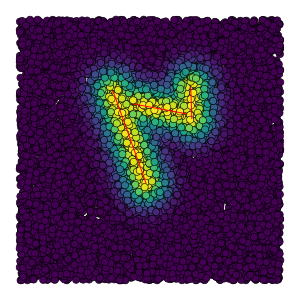

In [7]:
segs = [Segment(rand(2), rand(2)) for t=1:3]
xs = [2*rand(2) .- 0.5 for t=1:10_000]
ds = distance.(xs, [segs])
ds = exp.(-ds.^2/0.025)    

# ----------
plot(size=(300,300), aspect_ratio=:equal, legend=false, axis=([], false))
scatter!(xs, zcolor=ds, c=:viridis, markersize=4)
plot!(segs, c=:red)

## Raycaster

In [8]:
#nbx
function line_intersect(x, x′, y, y′)
    dx = x′ - x
    dy = y′ - y
    if det([-dx dy]) == 0
        return [Inf;Inf]
    end
    s, t = inv([-dx dy])*(x - y)
    return s,t
end;

In [9]:
#nbx
function cast(ray::Segment, seg::Segment)
    x,x′ = ray.x, ray.y
    y,y′ = seg.x, seg.y
    dx = x′ - x
    s,t = line_intersect(x, x′, y, y′)
    if s == Inf
       return false, nothing 
    elseif 0 <= s && 0 <= t <= 1
        return true, s*norm(dx)
    else
        return false, nothing
    end
end

function cast(x::Vector{Float64}, hd::Float64, seg::Segment)
    ray = Segment(x,x+[cos(hd);sin(hd)])
    return cast(ray, seg)
end

function cast(x::Vector{Float64}, hd::Float64, a::Vector{Float64}, segs::Vector{Segment}; zmax=100) 
    z = ones(length(a))*zmax
    for i in 1:length(a), s in segs
        hit, d = cast(x, a[i] + hd, s)
        if hit
            z[i] = min(z[i], d)
        end
    end
    return z
end

export cast

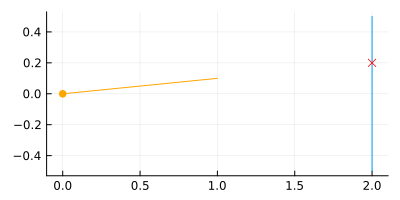

In [10]:
ray = Segment([0;0],[1;0.1])
seg = Segment([2;0.5], [2;-0.5])
hit, d = cast(ray, seg)
# -------------
myplot = plot(size=(400,200), aspect_ratio=:equal, legend=nothing)
plot!(ray, c=:orange)
scatter!([ray.x], marker=:o, c=:orange, markerstrokewidth=0)
plot!(seg, c=col[1])
if hit
    scatter!([ray.x + d*diff(ray)/norm(ray)], marker=:x, c=:red, markerstrokewidth=2);
end
myplot

## Benchmark

In [21]:
using BenchmarkTools

num_a    = 361;
num_segs = 500;


x    = [0.5;0.5]
hd   = 0.0
fov  = 2π
zmax = 20
a    = collect(range(-fov/2,fov/2, num_a))
segs = [Segment(rand(2), rand(2)) for t=1:num_segs]


function bench_cast(x,hd,a,segs)
    z = cast(x, hd, a, segs)
end

bench_cast (generic function with 1 method)

In [22]:
@btime bench_cast($x,$hd,$a,$segs);

  247.203 ms (3066502 allocations: 415.26 MiB)


This is way too slow to be usable (`|a|=361`, `|segs|=500`)
```julia
@btime bench_cast($x,$hd,$a,$segs);
>> 247.203 ms (3066502 allocations: 415.26 MiB)

```

# Create Observations along path

In [12]:
import JSON

fname = "data/path_data.json"
d = JSON.parsefile(fname)

println(keys(d))

segs = segments(Array{Float64}.(d["verts"]));
paths = [Array{Float64}.(path) for path in d["paths"]];

["env_name", "verts", "paths"]


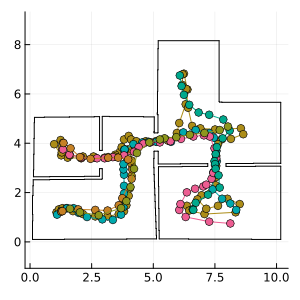

In [13]:
myplot = plot(size=(300,300), aspect_ratio=:equal)
plot!(segs, label=nothing, c="black")
for path in paths
    plot!(path, marker=:o, label=nothing)
end
myplot

(33,)(33,)(32,)(32,)


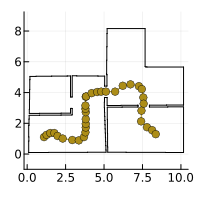

In [75]:
# Choose path
i = 2
path = paths[i]

# Unpack path into 
# poses and controls
xs   = path
dxs  = xs[2:end] - xs[1:end-1]
hds  = MyUtils.angle.(dxs)
dhds = hds[2:end] - hds[1:end-1];
xs   = xs[1:end-1]
dxs  = dxs[1:end-1]


println(size(xs), size(hds), size(dxs), size(dhds))
    
plot(size=(200,200), aspect_ratio=:equal)
plot!(segs, label=nothing, c="black")
plot!(path, marker=:o, label=nothing)

In [76]:
fov  = 2π
zmax = 20
as = collect(range(-fov/2,fov/2, 361))

# Compute measurements along path
zs = []
for (x,hd) in zip(xs, hds)
    push!(zs, cast(x, hd, as, segs))
end
    
size(zs)

(33,)

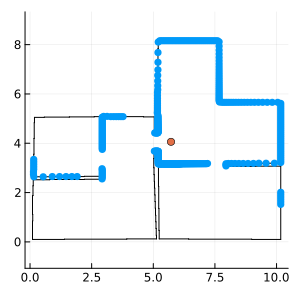

In [77]:
t = rand(1:length(xs))
z = zs[t]
x = xs[t]
hd = hds[t]

obs = [x] .+ z .* unit_vec.(as .+ hd)

# -------------------
myplot = plot(size=(300,300), aspect_ratio=:equal, legend=nothing)
plot!(segs, label=nothing, c="black")
scatter!([x[1]], [x[2]], c=col[2])
scatter!(obs, markerstrokewidth=0.0, c=col[1])

In [78]:
data = Dict(
    :env => Dict(
        :segs => segs
    ),
    :motion => Dict(
        :x => xs,
        :hd => hds,
        :dx => dxs,
        :dhd => dhds
    ),
    :sensor => Dict(
        :a => as,
        :z => zs,
        :fov => fov,
        :zmax => zmax
    )
)

using JLD2
fname = "data/data_2.jld2"
save_object(fname, data)

In [79]:
data = load_object(fname)

Dict{Symbol, Dict{Symbol}} with 3 entries:
  :env    => Dict{Symbol, Vector{Segment}}(:segs=>[Segment([0.11, 0.1], [0.1, 0…
  :sensor => Dict{Symbol, Any}(:a=>[-3.14159, -3.12414, -3.10669, -3.08923, -3.…
  :motion => Dict{Symbol, Vector}(:x=>[[1.09725, 1.10467], [1.26401, 1.2476], […

In [80]:
data = Dict(
    :env => Dict(
        :segs => vec.(segs)
    ),
    :motion => Dict(
        :x   => xs,
        :hd  => hds,
        :dx  => dxs,
        :dhd => dhds
    ),
    :sensor => Dict(
        :a => as,
        :z => zs,
        :fov  => fov,
        :zmax => zmax
    )
)

fname = "data/data_2.json"
open(fname,"w") do f
    JSON.print(f, data)
end